In [1]:
from src.vectorstorage import EmbeddingVectorStorage
from src.custom_embeddings import CustomHuggingFaceEndpointEmbeddings
import pandas as pd


with open("secrets.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith("api_token"):
            token = line.split("=")[1].strip()

bge_m3_embed = CustomHuggingFaceEndpointEmbeddings(
    model_name="BAAI/bge_m3",
    model="http://100.67.185.22:8080",
    huggingfacehub_api_token=token,
    model_kwargs={"normalize_embeddings": True},
)

stella_embed = CustomHuggingFaceEndpointEmbeddings(
    model_name="dunzhang/stella_en_1.5B_v5",
    model="http://100.67.185.22:8083",
    huggingfacehub_api_token=token,
    model_kwargs={"normalize_embeddings": True},
)

nomic_embed = CustomHuggingFaceEndpointEmbeddings(
    model_name="nomic-ai/nomic-embed-text-v1.5",
    model="http://100.67.185.22:8082",
    huggingfacehub_api_token=token,
    model_kwargs={"normalize_embeddings": True},
)

In [2]:
# BAAI_bge_m3_RecursiveCharacterTextSplitter
# Alibaba-NLP_gte-Qwen2-7B_RecursiveCharacterTextSplitter
# nomic-ai_nomic-embed-text-v1_5_RecursiveCharacterTextSplitter

collection_name = "BAAI_bge_m3_RecursiveCharacterTextSplitter"
path_persistent = "./data/chroma"

# Reload the vector store
bge_m3_vectordb = EmbeddingVectorStorage(
    method_of_embedding=bge_m3_embed,
    collection=collection_name,
    path_persistent=path_persistent,
)

print(bge_m3_vectordb)

VectorStorage(method_of_embedding=CustomHuggingFaceEndpointEmbeddings, group=BAAI_bge_m3_RecursiveCharacterTextSplitter)


In [3]:
print(bge_m3_vectordb.test_heartbeat())  # Check if the Chroma client is active
print(bge_m3_vectordb.collection_is_empty())  # Check if the collection is empty

1732091199048642000
False


In [4]:
query = "The company is also aiming to reduce gas flaring?"
bge_m3_vectordb.search_similar_w_scores(query)

[(Document(metadata={'date': '2021-12-13', 'domain': 'naturalgasintel', 'origin_doc_id': '955ad75cdc5396c0057252d76df2c445', 'title': 'ExxonMobil Envisions Carbon-Neutral Permian Operations by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-envisions-carbon-neutral-permian-operations-by-2030/'}, page_content='their natural gas prices off of NGI s Mexico Gas Price Index. Read the analysis of our fifth survey of active players in Mexico, showcasing market driven insights now. , The company plans to electrify its operations with low carbon power, which may include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its Permian ope

In [26]:
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain_ollama import OllamaLLM

qwen2_5_0_5b_model = "qwen2.5:0.5b-instruct-q4_0"
qwen2_5_1_5b_model = "qwen2.5:1.5b-instruct-q4_0"
qwen2_5_3b_model = "qwen2.5:3b-instruct-q4_0"
llama3_2_3b = "llama3.2:3b-instruct-q6_K"
llama_1b = "llama3.2:1b-instruct-q4_0"
qwen2_5_7b = "qwen2.5:7b-instruct-q4_0"

basic_retriever = bge_m3_vectordb.as_retriever()
llm_model = OllamaLLM(model=qwen2_5_0_5b_model)

In [27]:
from langchain import hub
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel
from dotenv import load_dotenv

load_dotenv()

# https://python.langchain.com/v0.1/docs/use_cases/question_answering/sources/
# prompt: https://smith.langchain.com/hub/rlm/rag-prompt?organizationId=2d6cd9b7-5b49-44db-a523-a13c23f12f29
basic_prompt = hub.pull("rlm/rag-prompt")


def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)


rag_chain_from_docs = (
    RunnablePassthrough.assign(context=(lambda x: format_docs(x["context"])))
    | basic_prompt
    | llm_model
    | StrOutputParser()
)

basic_rag_chain = RunnableParallel(
    {"context": basic_retriever, "question": RunnablePassthrough()}
).assign(answer=rag_chain_from_docs)

basic_rag_chain.invoke("The company is also aiming to reduce gas flaring?")

{'context': [Document(metadata={'date': '2021-12-13', 'domain': 'naturalgasintel', 'origin_doc_id': '955ad75cdc5396c0057252d76df2c445', 'title': 'ExxonMobil Envisions Carbon-Neutral Permian Operations by 2030', 'url': 'https://www.naturalgasintel.com/exxonmobil-envisions-carbon-neutral-permian-operations-by-2030/'}, page_content='their natural gas prices off of NGI s Mexico Gas Price Index. Read the analysis of our fifth survey of active players in Mexico, showcasing market driven insights now. , The company plans to electrify its operations with low carbon power, which may include wind, solar, hydrogen, natural gas with carbon capture and storage, or other emerging technologies, the firm said. ExxonMobil plans to expand its methane detection programs utilizing satellite surveillance and a network of ground based sensors for continuous monitoring, and aerial flyovers that identify leaks for rapid repairs. , By the end of this year, ExxonMobil plans to reduce flaring volumes across its 

In [28]:
import pandas as pd

clean_dataset = pd.read_parquet("data/preprocessed/clean_cleantech.parquet")

In [29]:
eval_test = pd.read_csv(
    "data/eval_dataset/cleantech_rag_evaluation_data_2024-09-20.csv", sep=";"
)

In [30]:
from fuzzywuzzy import fuzz


def compute_similarity(text_1, text_2):
    return fuzz.partial_ratio(text_1, text_2)


def find_most_similar(clean_df, eval_input_chunk):

    similarity_score = 0
    similarity_score_index = None

    for idx, doc in clean_df.iterrows():
        score = compute_similarity(eval_input_chunk, doc["content"])
        if score > similarity_score:
            similarity_score = score
            similarity_score_index = doc["id"]

    return similarity_score, similarity_score_index

In [31]:
from tqdm import tqdm
from pandarallel import pandarallel

tqdm.pandas()
pandarallel.initialize(progress_bar=True)


def apply_find_most_similar(row, clean_df):
    score, score_index = find_most_similar(clean_df, row["relevant_text"])
    return pd.Series([score, score_index])


# Make sure your DataFrames are named as 'clean_dataset' and 'eval_test'
eval_test[["top_score", "top_score_id"]] = eval_test.parallel_apply(
    apply_find_most_similar, args=(clean_dataset,), axis=1
)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [32]:
eval_test.head(5)

,example_id,question_id,question,relevant_text,answer,article_url,top_score,top_score_id
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,https://www.sgvoice.net/strategy/technology/23...,96,d4e62c94318b4b2d09a1f9519b9ba65b
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,0ff0fa30dbc4a6cedb659fa0d221ec83
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,https://www.pv-magazine.com/2023/02/02/europea...,98,80181cd176814323bb67524614a2f11e
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,0ff0fa30dbc4a6cedb659fa0d221ec83
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,https://cleantechnica.com/2023/05/08/general-m...,100,4411ffe0103fa4d5d9f00addb04806dd


In [33]:
eval_test = eval_test.drop_duplicates().copy()

In [34]:
eval_test = eval_test.rename(columns={"answer": "ground_truth"})

In [35]:
eval_test.head(5)

,example_id,question_id,question,relevant_text,ground_truth,article_url,top_score,top_score_id
0,1,1,What is the innovation behind Leclanché's new ...,Leclanché said it has developed an environment...,Leclanché's innovation is using a water-based ...,https://www.sgvoice.net/strategy/technology/23...,96,d4e62c94318b4b2d09a1f9519b9ba65b
1,2,2,What is the EU’s Green Deal Industrial Plan?,The Green Deal Industrial Plan is a bid by the...,The EU’s Green Deal Industrial Plan aims to en...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,0ff0fa30dbc4a6cedb659fa0d221ec83
2,3,2,What is the EU’s Green Deal Industrial Plan?,The European counterpart to the US Inflation R...,The EU’s Green Deal Industrial Plan aims to en...,https://www.pv-magazine.com/2023/02/02/europea...,98,80181cd176814323bb67524614a2f11e
3,4,3,What are the four focus areas of the EU's Gree...,The new plan is fundamentally focused on four ...,The four focus areas of the EU's Green Deal In...,https://www.sgvoice.net/policy/25396/eu-seeks-...,100,0ff0fa30dbc4a6cedb659fa0d221ec83
4,5,4,When did the cooperation between GM and Honda ...,What caught our eye was a new hookup between G...,July 2013,https://cleantechnica.com/2023/05/08/general-m...,100,4411ffe0103fa4d5d9f00addb04806dd


In [36]:
questions = eval_test["question"].to_list()
ground_truth = eval_test["ground_truth"].to_list()

questions, ground_truth

(["What is the innovation behind Leclanché's new method to produce lithium-ion batteries?",
  'What is the EU’s Green Deal Industrial Plan?',
  'What is the EU’s Green Deal Industrial Plan?',
  "What are the four focus areas of the EU's Green Deal Industrial Plan?",
  'When did the cooperation between GM and Honda on fuel cell vehicles start?',
  'Did Colgate-Palmolive enter into PPA agreements with solar developers?',
  "What is the status of ZeroAvia's hydrogen fuel cell electric aircraft?",
  'What is the "Danger Season"?',
  'Is Mississipi an anti-ESG state?',
  'Can you hang solar panels on garden fences?',
  'Who develops quality control systems for ocean temperature in-situ profiles?',
  'Why are milder winters detrimental for grapes and apples?',
  'What are the basic recycling steps for solar panels?',
  'Why does melting ice contribute to global warming?',
  'Does the Swedish government plan bans on new petrol and diesel cars?',
  'Where do the turbines used in Icelandic geot

In [37]:
from datasets import Dataset

ground_truth_nested = [[item] for item in ground_truth]

data = {
    "user_input": [],
    "retrieved_contexts": [],
    "reference_contexts": ground_truth_nested,
    "response": [],
    "reference": ground_truth,
}

for query in tqdm(questions):
    result_chain = basic_rag_chain.invoke(query)
    retrieved_contexts = [doc.page_content for doc in result_chain["context"]]
    data["user_input"].append(query)
    data["retrieved_contexts"].append(retrieved_contexts)
    data["response"].append(basic_rag_chain.invoke(query)["answer"])

dataset = Dataset.from_dict(data)
dataset

100%|██████████| 23/23 [00:46<00:00,  2.01s/it]


Dataset({
    features: ['user_input', 'retrieved_contexts', 'reference_contexts', 'response', 'reference'],
    num_rows: 23
})

In [38]:
dataset[0]

{'user_input': "What is the innovation behind Leclanché's new method to produce lithium-ion batteries?",
 'retrieved_contexts': ['process safer for employees. Leclanch claims to be a global pioneer in the field, having used aqueous binders in its for over a decade. , A further benefit of the water based process is a lower carbon footprint, as it uses 30 less energy, which would otherwise be needed to dry, or evaporate, and recycle the solvents. , With the water based production of the high capacity NMCA cathodes, we have reached a decisive milestone in lithium ion technology, said Dr Hilmi Buqa, vice president R D at Leclanch . Until now, producing them using environmentally friendly processes was considered impossible. But, now we have mastered the process. , In developing its new G NMCA battery, Leclanch has increased the nickel content of the cathode to around 90 , which has the effect of increasing the energy density. The G refers to the graphite anode. Increasing the nickel conten

In [19]:
import pickle

with open(f"{llm_model.model}_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [20]:
dataset[0]

{'user_input': "What is the innovation behind Leclanché's new method to produce lithium-ion batteries?",
 'retrieved_contexts': ['process safer for employees. Leclanch claims to be a global pioneer in the field, having used aqueous binders in its for over a decade. , A further benefit of the water based process is a lower carbon footprint, as it uses 30 less energy, which would otherwise be needed to dry, or evaporate, and recycle the solvents. , With the water based production of the high capacity NMCA cathodes, we have reached a decisive milestone in lithium ion technology, said Dr Hilmi Buqa, vice president R D at Leclanch . Until now, producing them using environmentally friendly processes was considered impossible. But, now we have mastered the process. , In developing its new G NMCA battery, Leclanch has increased the nickel content of the cathode to around 90 , which has the effect of increasing the energy density. The G refers to the graphite anode. Increasing the nickel conten

In [24]:
from langchain.callbacks.base import AsyncCallbackHandler
from langchain.callbacks.tracers import LangChainTracer
from ragas import RunConfig

run_config = RunConfig(
    timeout=3600,
)

from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_entity_recall,
    answer_similarity,
    answer_correctness,
)

ragas_metrics = [
    # faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    context_entity_recall,
    answer_similarity,
    answer_correctness,
]

In [25]:
import os

with open("secrets.txt", "r") as f:
    lines = f.readlines()
    for line in lines:
        if line.startswith("openai"):
            openaitoken = line.split("=")[1].strip()

os.environ["OPENAI_API_KEY"] = openaitoken

from ragas.llms import LangchainLLMWrapper
from ragas.embeddings import LangchainEmbeddingsWrapper
from langchain_openai import ChatOpenAI

evaluator_llm = LangchainLLMWrapper(ChatOpenAI(model="gpt-4o-mini"))

faithfulness.adapt_prompts(language="english", llm=evaluator_llm)

<coroutine object PromptMixin.adapt_prompts at 0x3596fed40>

In [26]:
from ragas import evaluate

baseline_test_result = evaluate(
    dataset=dataset,
    metrics=ragas_metrics,
    llm=evaluator_llm,
    embeddings=bge_m3_embed,
    raise_exceptions=True,
    show_progress=True,
    run_config=run_config,
)

Evaluating:   0%|          | 0/161 [00:00<?, ?it/s]

/opt/anaconda3/envs/npr_rag_hs24/lib/python3.9/site-packages/pydantic/main.py:390: UserWarning: Pydantic serializer warnings:
  Expected `dict[str, any]` but got `EvaluationResult` with value `{'answer_relevancy': 0.74...er_correctness': 0.3454}` - serialized value may not be as expected
  Expected `dict[str, any]` but got `EvaluationResult` with value `{'answer_relevancy': 0.74...er_correctness': 0.3454}` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [28]:
baseline_test_result

{'answer_relevancy': 0.7436, 'context_recall': 0.6957, 'context_precision': 0.6920, 'context_entity_recall': 0.1497, 'semantic_similarity': 0.6273, 'answer_correctness': 0.3454}

In [29]:
baseline_test_result.to_pandas()

,user_input,retrieved_contexts,reference_contexts,response,reference,answer_relevancy,context_recall,context_precision,context_entity_recall,semantic_similarity,answer_correctness
0,What is the innovation behind Leclanché's new ...,[process safer for employees. Leclanch claims ...,[Leclanché's innovation is using a water-based...,Leclanché's innovation involves using a water-...,Leclanché's innovation is using a water-based ...,0.829993,1.0,1.000000,0.000000,0.891642,0.651482
1,What is the EU’s Green Deal Industrial Plan?,[The EU has presented its Green Deal Industria...,[The EU’s Green Deal Industrial Plan aims to e...,The EU's Green Deal Industrial Plan aims to bo...,The EU’s Green Deal Industrial Plan aims to en...,0.934858,1.0,1.000000,0.400000,0.944703,0.351560
2,What is the EU’s Green Deal Industrial Plan?,[The EU has presented its Green Deal Industria...,[The EU’s Green Deal Industrial Plan aims to e...,The EU's Green Deal Industrial Plan aims to bo...,The EU’s Green Deal Industrial Plan aims to en...,0.934858,1.0,1.000000,0.400000,0.905490,0.440658
3,What are the four focus areas of the EU's Gree...,[The EU has presented its Green Deal Industria...,[The four focus areas of the EU's Green Deal I...,The four focus areas of the EU's Green Deal In...,The four focus areas of the EU's Green Deal In...,0.937976,1.0,0.500000,0.000000,1.000000,1.000000
4,When did the cooperation between GM and Honda ...,[market. The collaboration launched in July of...,[July 2013],The cooperation between GM and Honda on fuel c...,July 2013,0.999999,1.0,1.000000,0.000000,0.467052,0.116763
5,Did Colgate-Palmolive enter into PPA agreement...,[Colorado based solar developer Scout Clean En...,[yes],"Yes, Colgate-Palmolive entered into a power pu...",yes,0.774930,1.0,0.916667,0.000000,0.435775,0.108944
6,What is the status of ZeroAvia's hydrogen fuel...,[The fuel cell startup ZeroAvia is laying plan...,[ZeroAvia's hydrogen fuel cell electric aircra...,ZeroAvia has received permission to conduct te...,ZeroAvia's hydrogen fuel cell electric aircraf...,0.855750,1.0,0.583333,0.250000,0.833188,0.395797
7,"What is the ""Danger Season""?","[DNV, a provider of advisory, monitoring, veri...","[The ""Danger Season"" is the period in the Nort...","The context does not mention any ""Danger Seaso...","The ""Danger Season"" is the period in the North...",0.000000,0.0,0.000000,0.142857,0.600700,0.150175
8,Is Mississipi an anti-ESG state?,[State office holders in Mississippi continue ...,[yes],Mississippi has anti-ESG rhetoric from its pub...,yes,0.000000,0.0,0.916667,0.000000,0.405520,0.101380
9,Can you hang solar panels on garden fences?,"[I recently wrote about tiltable, portable sol...",[yes],"Yes, you can hang solar panels on garden fence...",yes,0.981968,1.0,1.000000,0.000000,0.404254,0.101063


In [30]:
baseline_test_result.to_pandas().to_csv("data/basline_test_result.csv")

In [31]:
import pandas as pd

result = pd.read_csv("data/basline_test_result.csv")

result.columns

Index(['Unnamed: 0', 'user_input', 'retrieved_contexts', 'reference_contexts',
       'response', 'reference', 'answer_relevancy', 'context_recall',
       'context_precision', 'context_entity_recall', 'semantic_similarity',
       'answer_correctness'],
      dtype='object')

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_boxplot(csv_file):
    # Read data from CSV file
    df = pd.read_csv(csv_file)

    # List of columns you want to plot
    columns = [
        "answer_relevancy",
        "context_precision",
        "context_entity_recall",
        "semantic_similarity",
        "answer_correctness",
    ]

    # Use a valid Matplotlib style
    plt.style.use("seaborn-v0_8-darkgrid")  # Updated to use a valid Matplotlib style

    # Set up the figure size
    plt.figure(figsize=(12, 6))

    # Create a boxplot with swarmplot overlay for data points
    sns.boxplot(data=df[columns], palette="Set2", width=0.6, linewidth=1.5)
    sns.stripplot(data=df[columns], color="black", size=4, alpha=0.7, jitter=True)

    # Add a title and labels
    plt.title("Boxplot of Scores", fontsize=16)
    plt.ylabel("Score", fontsize=14)
    plt.xticks(fontsize=12, rotation=20)  # Rotate x-axis labels for better readability

    # Tight layout for better spacing
    plt.tight_layout()

    # Show the plot
    plt.show()

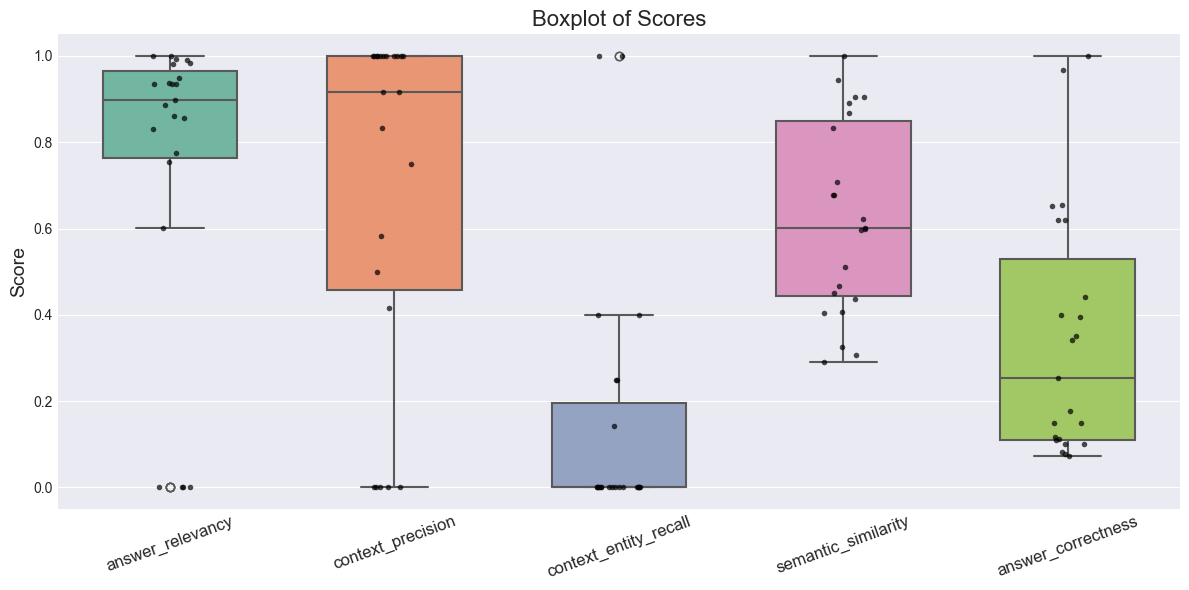

In [35]:
plot_boxplot("data/basline_test_result.csv")

In [ ]:
from langchain_openai import ChatOpenAI
from src.evaluation import Evaluation

# Initialize the class
rag_chain = ...  # Your RAG chain instance
llm_model = ChatOpenAI(model="gpt-3.5-turbo")
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-m3")

evaluator = Evaluation(
    name="Cleantech Evaluation",
    rag_chain=rag_chain,
    llm_model=llm_model,
    embeddings=embeddings,
)

# Evaluate (preprocessing and dataset preparation happens automatically)
results = evaluator.evaluate(
    clean_file="data/preprocessed/clean_cleantech.parquet",
    eval_file="data/eval_dataset/cleantech_rag_evaluation_data_2024-09-20.csv",
)

# Save results to CSV and plot
results.to_csv("evaluation_results_old.csv", index=False)
evaluator.plot_result("evaluation_results_old.csv")